# MODELING TRAFFIC-DENSTIY OF THE CITY OF VIENNA
<i> Part 1: Simulating Paths</i>
***

In this project I attempt to model the traffic-density for the City of Vienna solely based on publicly available data.<br><br>
<b>Data Sources:</b> 
- <u>Road network:</u> The official road network from (https://www.data.gv.at/) consists of information on ~30000 street segments and its respective geolocation and street-type.
- <u>Uber rides:</u> Information on Uber rides per City can be accessed at (https://movement.uber.com/). Uber is splitting the City of Vienna into 1370 subdistricts where travel-time between these starting & ending-areas is reported. Additional categorical information about weekdays or time of the day are available.

<b>Approach:</b><br><br>
<u>Part 1: Simulating Paths</u>
<ul>
    <li>Initialize a network graph consisting of all recorded streets of the City of Vienna</li>
    <li>Map maximum speed-limit to each network edge dependent on its street-type</li>
    <li>Calculate the shortest path of streets between pairs of start/end-nodes in the network</li>
    <li>Collect shortest path information for every start/end combination observed in the set of Uber rides</li>
</ul>

<u>Part 2: Constrained Optimization</u>
<ul>
    <li>Frame a constrained optimiziation problem to derive a "traffic-coefficient" per each area, representing its traffic-density</li>
    <li>Analyze traffic-density per area during different times of the day</li>

<img src="img/cover.jpg" alt="Drawing" style="width: 800px;"/><br>

<center>
    Photo by <a href="https://unsplash.com/@ahmgeek?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Ahmad Tolba</a> on <a href="https://unsplash.com/s/photos/vienna-cars?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
   </center>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Imports-&amp;-Settings" data-toc-modified-id="1-Imports-&amp;-Settings-1">1 Imports &amp; Settings</a></span></li><li><span><a href="#2-Streets" data-toc-modified-id="2-Streets-2">2 Streets</a></span></li><li><span><a href="#3-Areas" data-toc-modified-id="3-Areas-3">3 Areas</a></span><ul class="toc-item"><li><span><a href="#3.1-Load" data-toc-modified-id="3.1-Load-3.1">3.1 Load</a></span></li><li><span><a href="#3.2-Map-to-Streets" data-toc-modified-id="3.2-Map-to-Streets-3.2">3.2 Map to Streets</a></span></li></ul></li><li><span><a href="#4-Network" data-toc-modified-id="4-Network-4">4 Network</a></span><ul class="toc-item"><li><span><a href="#4.1-Initialize" data-toc-modified-id="4.1-Initialize-4.1">4.1 Initialize</a></span></li><li><span><a href="#4.2-Show-By-Street-Type" data-toc-modified-id="4.2-Show-By-Street-Type-4.2">4.2 Show By Street Type</a></span></li><li><span><a href="#4.3-Show-By-Disconnected-Nodes" data-toc-modified-id="4.3-Show-By-Disconnected-Nodes-4.3">4.3 Show By Disconnected Nodes</a></span></li><li><span><a href="#4.4-Prune-Network" data-toc-modified-id="4.4-Prune-Network-4.4">4.4 Prune Network</a></span></li></ul></li><li><span><a href="#5-Paths" data-toc-modified-id="5-Paths-5">5 Paths</a></span><ul class="toc-item"><li><span><a href="#5.1-Shortest-Path" data-toc-modified-id="5.1-Shortest-Path-5.1">5.1 Shortest Path</a></span></li><li><span><a href="#5.2-Path-Statistics" data-toc-modified-id="5.2-Path-Statistics-5.2">5.2 Path Statistics</a></span></li><li><span><a href="#5.3-Detailed-View" data-toc-modified-id="5.3-Detailed-View-5.3">5.3 Detailed View</a></span></li></ul></li><li><span><a href="#6-Uber" data-toc-modified-id="6-Uber-6">6 Uber</a></span></li><li><span><a href="#7-Calculate" data-toc-modified-id="7-Calculate-7">7 Calculate</a></span></li><li><span><a href="#8-Export" data-toc-modified-id="8-Export-8">8 Export</a></span></li></ul></div>

### 1 Imports & Settings
***

In [3]:
# Libraries for data processing
import numpy as np
import pandas as pd
import datetime

# Library for network analysis & plotting
import networkx as nx

# Library for geometrical analysis & plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as Centroid

# Library for progress bar
from tqdm.notebook import tqdm

In [4]:
# Custom library for areas data
import data_streets
import data_areas
import data_uber

import street_network

### 2 Streets
***

In [5]:
Streets = data_streets.Streets()
Streets.load_edges(filename="STRASSENGRAPHOGD.csv")
Streets.load_nodes(filename="STRASSENKNOTENOGD.csv")

In [6]:
Streets.edges.head()

STREET_NAME  NODE_FROM   NODE_TO DISTRICT  \
(10345987, 10345945)         Nesselgasse   10345987  10345945       17   
(10352967, 10352927)      Lainzer Straße   10352967  10352927       13   
(10343396, 10343407)   Klampfelberggasse   10343396  10343407       17   
(10346241, 10344951)    Simon-Denk-Gasse   10346241  10344951       09   
(10351035, 10351169)  Mariahilfer Straße   10351035  10351169       06   

                        DISTANCE  SPEED  TRAVEL_TIME   STREET_TYPE  
(10345987, 10345945)  101.818937     30    12.218272  local-street  
(10352967, 10352927)   91.229415     30    10.947530  local-street  
(10343396, 10343407)  161.468131     30    19.376176  local-street  
(10346241, 10344951)  145.706272     30    17.484753  local-street  
(10351035, 10351169)  129.467479     50     9.321659   main-street

In [7]:
Streets.nodes.head()

STREET_NAME        LNG  \
20048301                        Kreuzung auf Adolf-Loos-Weg  16.452634   
20048304                          Kreuzung auf Meistergasse  16.453923   
20048401                  Kreuzung auf Nelson-Mandela-Platz  16.504387   
20048421  Kreuzung zwischen Johann-Kutschera-Gasse und G...  16.499656   
20048943                         Kreuzung auf Erdbrustgasse  16.303960   

                LAT                                      POS  
20048301  48.267499   (16.452633779562802, 48.2674986690233)  
20048304  48.267410  (16.453923326739268, 48.26740953203255)  
20048401  48.233379  (16.504386981529663, 48.23337912023598)  
20048421  48.232692   (16.49965575911663, 48.23269157357505)  
20048943  48.214503  (16.30395988150427, 48.214502905814534)

### 3 Areas
***

#### 3.1 Load

In [8]:
# Instantiate network graph
Vienna = nx.Graph()

In [9]:
# Call areas class and execute its functions
Areas = data_areas.Areas()
Areas.load_data(filename="vienna_statistical_areas.json")
Areas.load_graph(graph=Vienna)

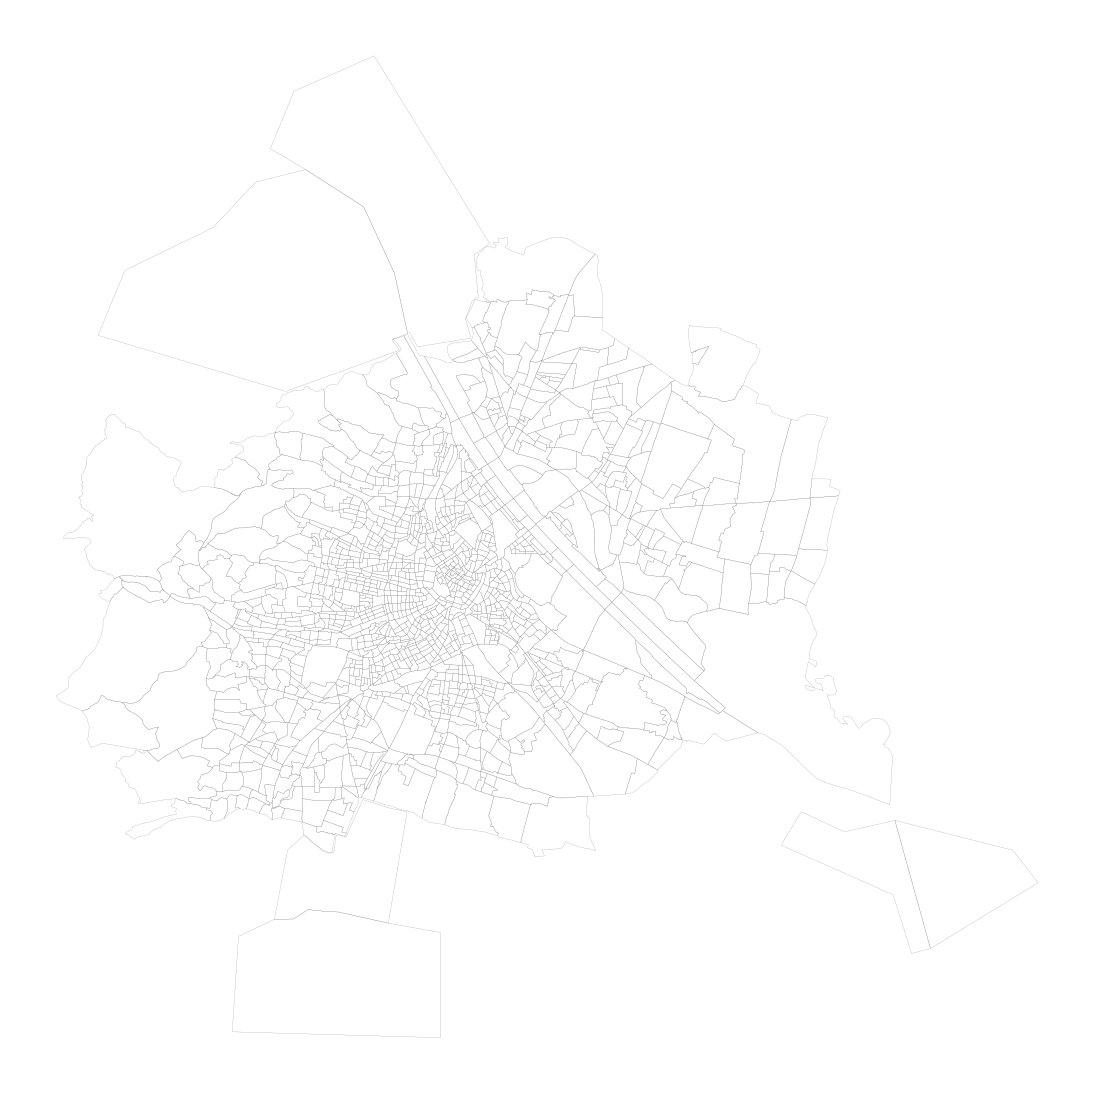

In [10]:
# Instantiate figure
plt.figure(figsize=(15,15))

# Draw graph
nx.draw(Vienna,
        pos=Areas.positions, 
        with_labels=False,
        edge_color="gray",
        width=0.2,
        node_color="gray",
        node_size=0)

plt.savefig("img/shapes.png", dpi=600)
plt.show()

#### 3.2 Map to Streets

In [11]:
Streets.add_areas(polygons=Areas.polygons)

  0%|          | 0/18726 [00:00<?, ?it/s]

In [12]:
Streets.edges.head()

STREET_NAME  NODE_FROM   NODE_TO DISTRICT  \
(10345987, 10345945)         Nesselgasse   10345987  10345945       17   
(10352967, 10352927)      Lainzer Straße   10352967  10352927       13   
(10343396, 10343407)   Klampfelberggasse   10343396  10343407       17   
(10346241, 10344951)    Simon-Denk-Gasse   10346241  10344951       09   
(10351035, 10351169)  Mariahilfer Straße   10351035  10351169       06   

                        DISTANCE  SPEED  TRAVEL_TIME   STREET_TYPE AREA_FROM  \
(10345987, 10345945)  101.818937     30    12.218272  local-street      0652   
(10352967, 10352927)   91.229415     30    10.947530  local-street      1144   
(10343396, 10343407)  161.468131     30    19.376176  local-street      0275   
(10346241, 10344951)  145.706272     30    17.484753  local-street      0664   
(10351035, 10351169)  129.467479     50     9.321659   main-street      0100   

                     AREA_TO  
(10345987, 10345945)    0652  
(10352967, 10352927)    1144  
(10343396, 10343407)    0275  
(10346241, 10344951)    0695  
(10351035, 10351169)    0100

In [13]:
Streets.nodes.head()

STREET_NAME        LNG  \
20048301                        Kreuzung auf Adolf-Loos-Weg  16.452634   
20048304                          Kreuzung auf Meistergasse  16.453923   
20048401                  Kreuzung auf Nelson-Mandela-Platz  16.504387   
20048421  Kreuzung zwischen Johann-Kutschera-Gasse und G...  16.499656   
20048943                         Kreuzung auf Erdbrustgasse  16.303960   

                LAT                                      POS  AREA  
20048301  48.267499   (16.452633779562802, 48.2674986690233)  0760  
20048304  48.267410  (16.453923326739268, 48.26740953203255)  0760  
20048401  48.233379  (16.504386981529663, 48.23337912023598)  0761  
20048421  48.232692   (16.49965575911663, 48.23269157357505)  0041  
20048943  48.214503  (16.30395988150427, 48.214502905814534)  0725

### 4 Network
***

#### 4.1 Initialize

In [95]:
from importlib import reload 
reload (street_network)

<module 'street_network' from 'C:\\Users\\bernh\\Jupyter scripts\\02 Projects New\\Vienna\\street_network.py'>

In [96]:
Network = street_network.Network()
Network.initialize(Streets)

In [97]:
print ("Network-Edges:")
display (Network.G.edges[Network.random_edge()])

print ("Network-Nodes:")
display (Network.G.nodes[Network.random_node()])

Network-Edges:


{'STREET_NAME': 'Leo-Mathauser-Gasse',
 'DISTRICT': '23',
 'DISTANCE': 193.618300911236,
 'SPEED': 30,
 'TRAVEL_TIME': 23.234196109348318,
 'STREET_TYPE': 'local-street',
 'AREA_FROM': '0869',
 'AREA_TO': '0869'}

Network-Nodes:


{'AREA': '1269'}

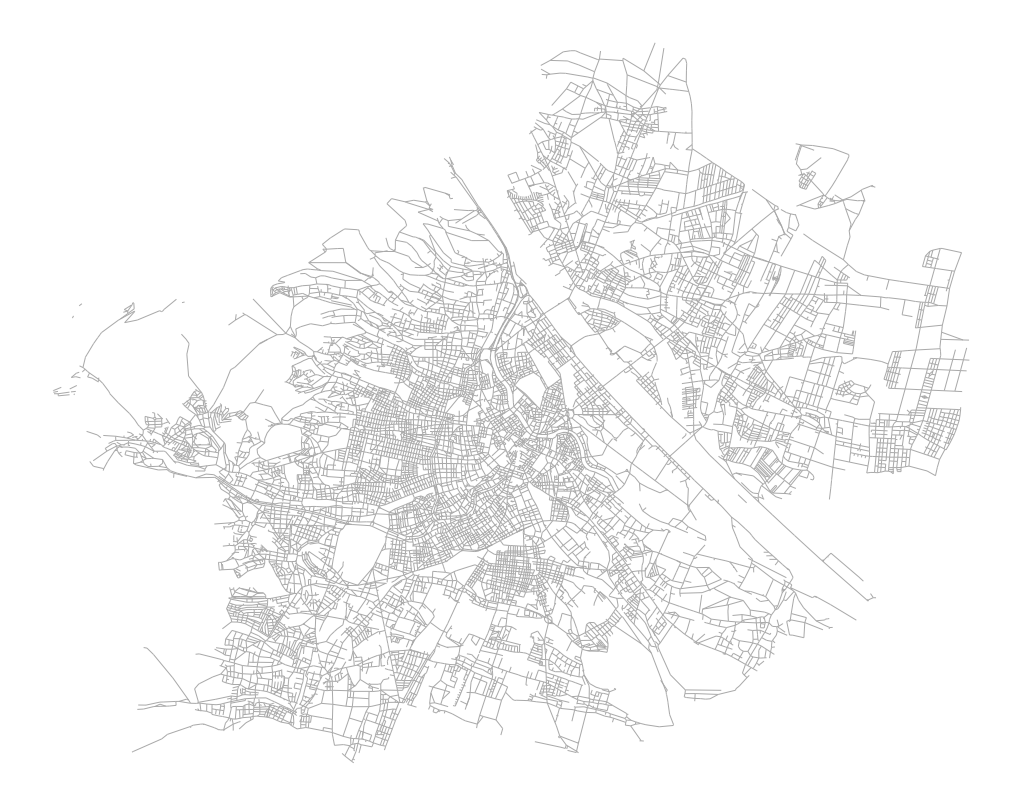

In [98]:
# Instantiate figure
plt.figure(figsize=(14,11))

# Draw graph
nx.draw(Network.G,
        pos=Streets.positions, 
        with_labels=False,
        edge_color=Network.colors,
        width=1,
        node_color="gray",
        node_size=0)

plt.show()

#### 4.2 Show By Street Type

In [99]:
Network.color_by_attr(Streets=Streets, attr="STREET_TYPE")

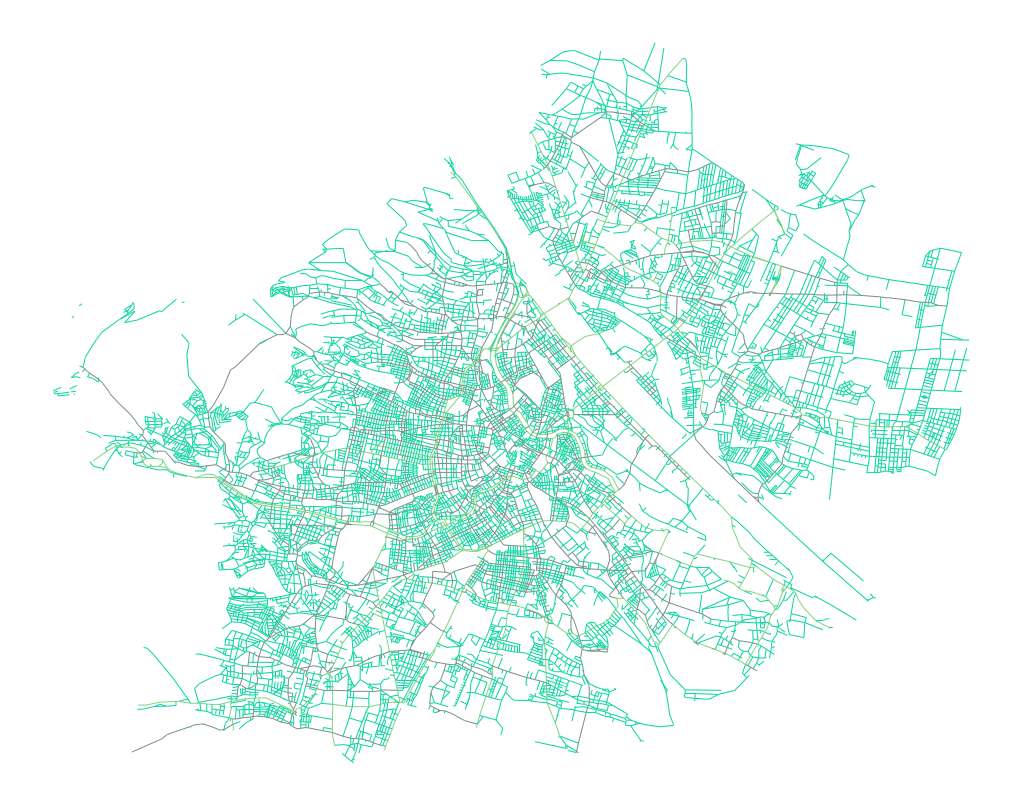

In [100]:
# Instantiate figure
plt.figure(figsize=(14,11))

# Draw graph
nx.draw(Network.G,
        pos=Streets.positions, 
        with_labels=False,
        edge_color=Network.colors,
        width=1,
        node_color="gray",
        node_size=0)

plt.savefig("img/network-by-type.png", dpi=600)
plt.show()

#### 4.3 Show By Disconnected Nodes

In [19]:
# Check if network is fully connected
nx.is_connected(Network.G)

False

In [20]:
Network.disconnected()
print ("Disconnected Network-Edges:")
display (Network.disconnect_edges[:10])

print ("Disconnected Network-Nodes:")
display (Network.disconnect_nodes[:10])

Disconnected Network-Edges:


[(18001437, 10356092),
 (18990127, 10341215),
 (20060720, 20060723),
 (20060720, 10353875),
 (10342451, 10342491),
 (10348596, 10348603),
 (10348596, 18790236),
 (10348603, 10348605),
 (10348603, 10348604),
 (10348605, 10348606)]

Disconnected Network-Nodes:


[18001437,
 18990127,
 20060720,
 20060723,
 10342451,
 10348596,
 10348603,
 10348604,
 10348605,
 10348606]

In [21]:
Network.color_by_path(
    path=Network.disconnect_edges, 
    color="red", 
    write_all=True)

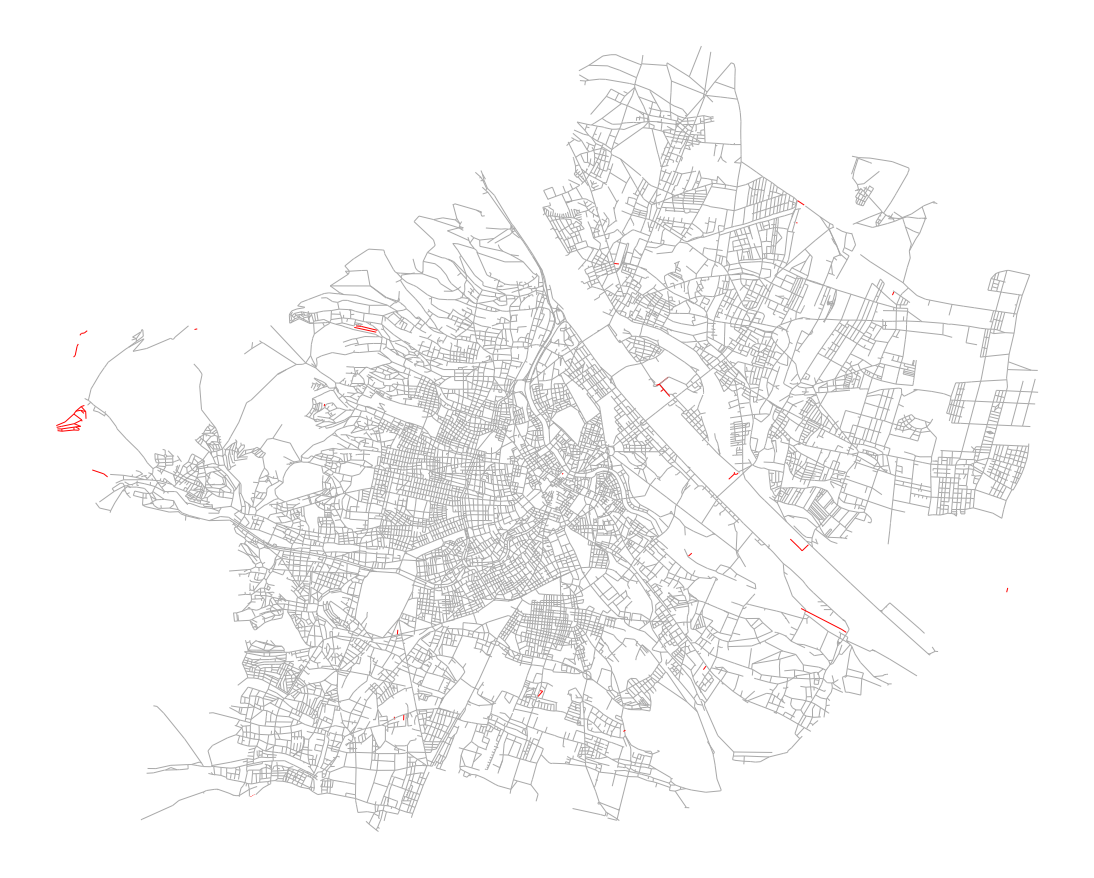

In [22]:
# Instantiate figure
plt.figure(figsize=(15,12))

# Draw graph
nx.draw(Network.G,
        pos=Streets.positions, 
        with_labels=False,
        edge_color=Network.colors,
        width=1,
        node_color="gray",
        node_size=0)

plt.savefig("img/network-pre-prune.png", dpi=600)
plt.show()

#### 4.4 Prune Network

In [23]:
# Prune the network by removing disconnected edges & nodes
Network.prune()

In [24]:
# Remove pruned nodes & edges also from streets data
Streets.nodes = Streets.nodes[~Streets.nodes.index.isin(Network.disconnect_nodes)]
Streets.edges = Streets.edges[~Streets.edges.index.isin(Network.disconnect_edges)]

In [25]:
# Check if network is fully connected
nx.is_connected(Network.G)

True

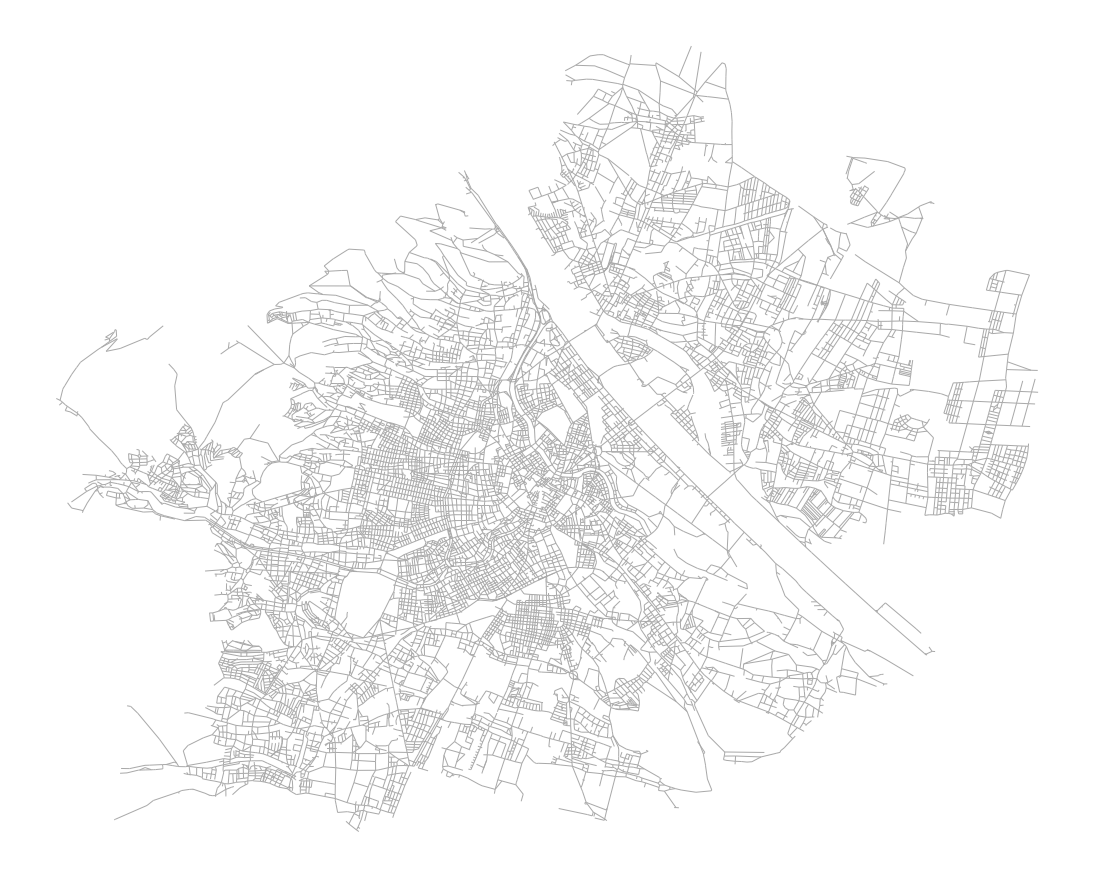

In [26]:
# Instantiate figure
plt.figure(figsize=(15,12))

# Draw graph
nx.draw(Network.G,
        pos=Streets.positions, 
        with_labels=False,
        edge_color=Network.colors,
        width=1,
        node_color="gray",
        node_size=0)

plt.savefig("img/network-post-prune.png", dpi=600)
plt.show()

### 5 Paths
***

#### 5.1 Shortest Path

In [123]:
Path = street_network.NetworkPath()

In [124]:
start_node = Network.random_node()
end_node = Network.random_node()

print (f"Start-node: {start_node}")
print (f"End-node: {end_node}")

Start-node: 10354312
End-node: 10348245


In [125]:
Path.shortest_path(
    G=Network.G,
    start_node=start_node, 
    end_node=end_node,
    metric="TRAVEL_TIME")

In [126]:
Network.color_by_path(
    path=Path.edges, 
    color="blue", 
    write_all=True)

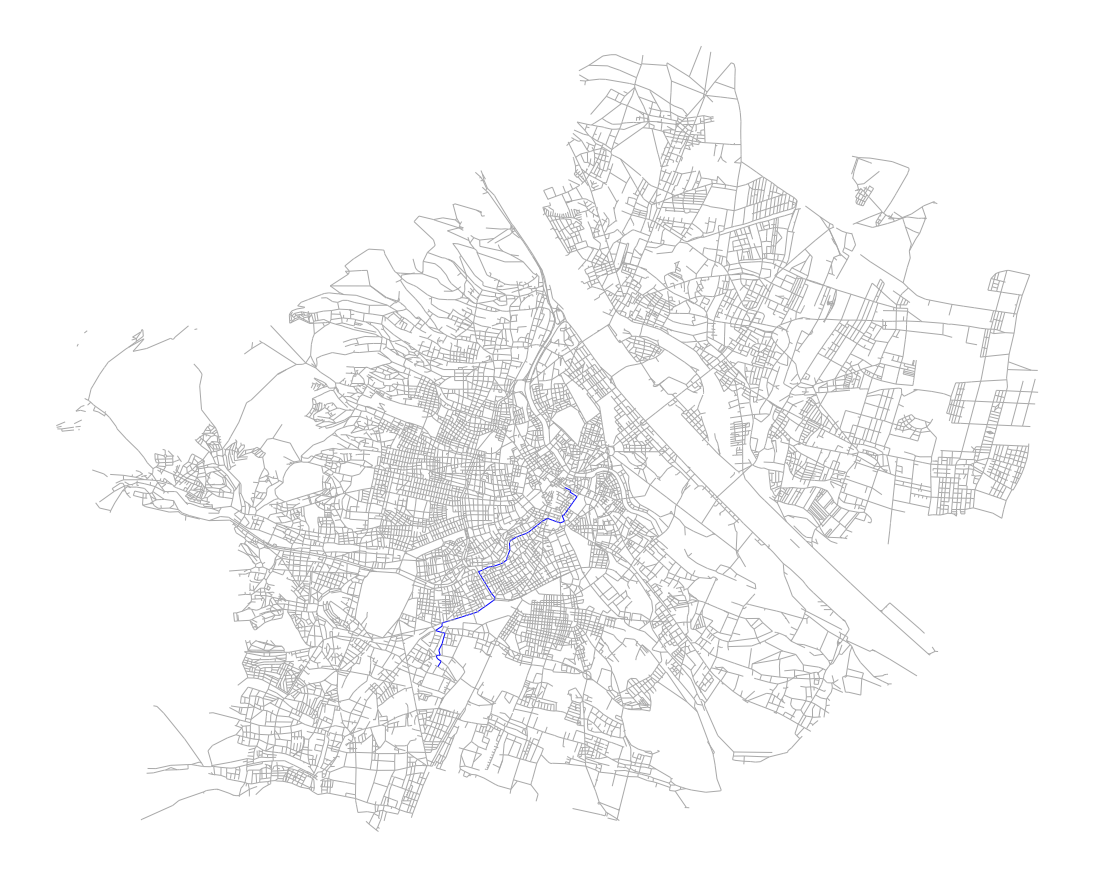

In [127]:
# Instantiate figure
plt.figure(figsize=(15,12))

# Draw graph
nx.draw(Network.G,
        pos=Streets.positions, 
        with_labels=False,
        edge_color=Network.colors,
        width=1,
        node_color="gray",
        node_size=0)

plt.savefig("img/network-path.png", dpi=600)
plt.show()

#### 5.2 Path Statistics

In [128]:
Path.summary

{'EST_CROSSINGS': 93,
 'EST_DISTANCE': 8802.81666375742,
 'EST_TRAVEL_TIME': 563.8092396502007}

In [129]:
print ("Network-Nodes of Path:")
display (Path.nodes[:10])

print ("Network-Edges of Path:")
display (Path.edges[:10])

Network-Nodes of Path:


[10354312,
 10354314,
 10354336,
 10354335,
 10459019,
 18819529,
 18819526,
 10354322,
 10354305,
 10354304]

Network-Edges of Path:


[(10354312, 10354314),
 (10354314, 10354336),
 (10354336, 10354335),
 (10459019, 10354335),
 (10459019, 18819529),
 (18819526, 18819529),
 (10354322, 18819526),
 (10354305, 10354322),
 (10354305, 10354304),
 (10354275, 10354304)]

In [130]:
print ("All areas passed:")
display(Path.areas[:5])

print ("Unique areas passed:")
display(Path.areas_unique[:5])

All areas passed:


['0440', '0941', '0941', '0941', '0941']

Unique areas passed:


['0440', '0941', '1253', '0797', '1218']

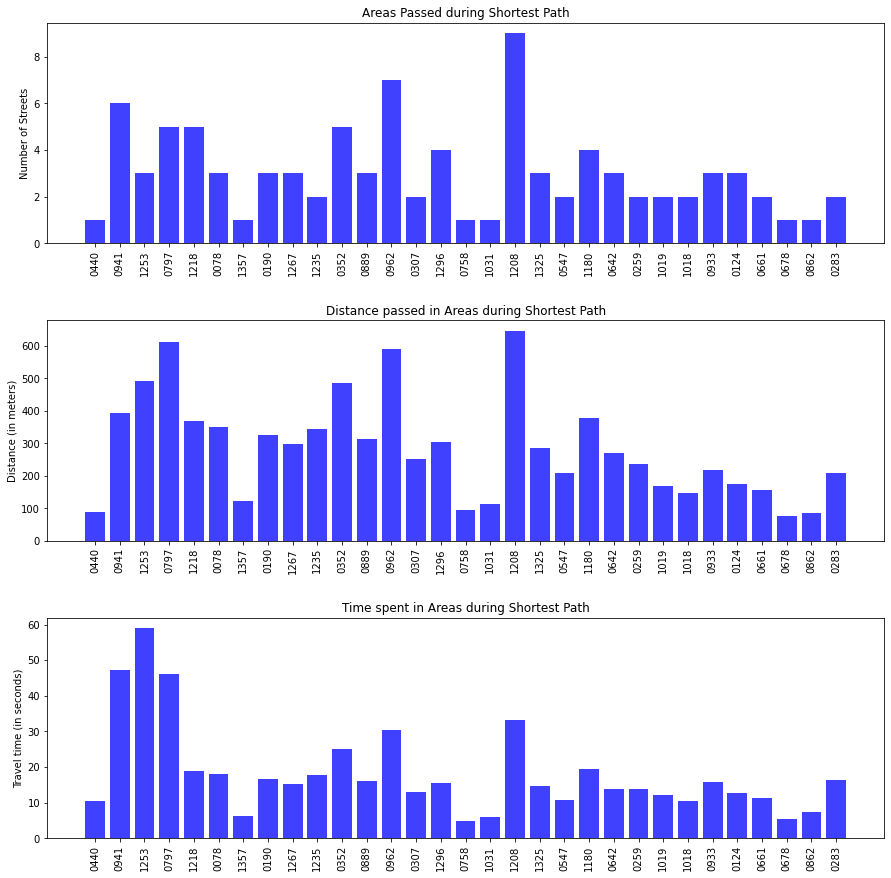

In [132]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,15))
fig.subplots_adjust(hspace=0.35)

# Axis #1 ---------------------------------------
ax[0].bar(x=Path.areas_count.index, height=Path.areas_count, color="blue", alpha=0.75)

ax[0].tick_params(axis="x", labelrotation=90)
ax[0].set_title("Areas Passed during Shortest Path")
ax[0].set_ylabel("Number of Streets")


# Axis #2 ---------------------------------------

# Change the metric to distance
Path.path_areas(G=Network.G, metric="DISTANCE")
idx = list(Path.areas_metric.keys())
height = list(Path.areas_metric.values())

ax[1].bar(x=idx, height=height, color="blue", alpha=0.75)

ax[1].tick_params(axis="x", labelrotation=90)
ax[1].set_title("Distance passed in Areas during Shortest Path")
ax[1].set_ylabel("Distance (in meters)")


# Axis 3 ---------------------------------------

# Change the metric to travel-time
Path.path_areas(G=Network.G, metric="TRAVEL_TIME")
idx = list(Path.areas_metric.keys())
height = list(Path.areas_metric.values())

ax[2].bar(x=idx, height=height, color="blue", alpha=0.75)

ax[2].tick_params(axis="x", labelrotation=90)
ax[2].set_title("Time spent in Areas during Shortest Path")
ax[2].set_ylabel("Travel time (in seconds)")

plt.savefig("img/path-stats.png", dpi=600)
plt.show()

#### 5.3 Detailed View

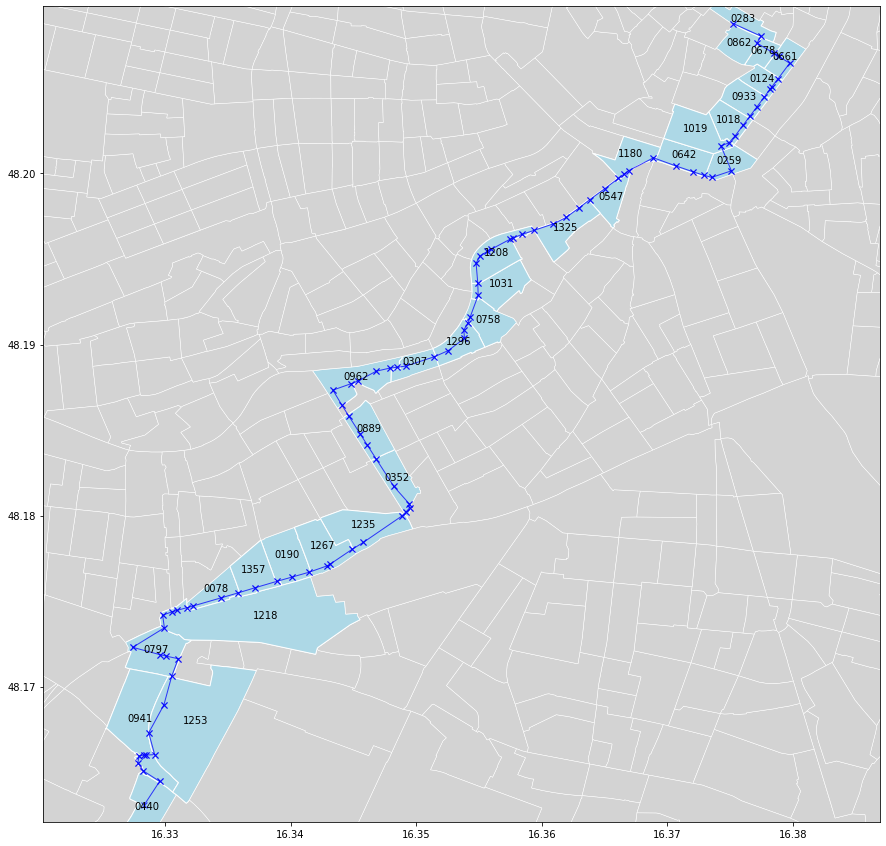

In [134]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))

# Set axis limits for figure
Path.get_limits(Streets=Streets)
ax.set_xlim(Path.xlim)
ax.set_ylim(Path.ylim)


for key,val in Areas.polygons.items():
    
    # Plot gray areas
    ax.add_patch(Polygon(val, 
        closed=True, 
        facecolor="lightgray", 
        edgecolor="white",
        linewidth=0.5))
    
    # Plot red areas
    if key in Path.areas_unique: 
        ax.add_patch(Polygon(val,
            closed=True, 
            facecolor="lightblue", 
            edgecolor="white",
            linewidth=1))
        
        x_center, y_center = Centroid(val).centroid.coords[0]
        ax.text(x=x_center, y=y_center, s=key, ha="center")


# Plot edges of path
for i in range(len(Path.nodes)):
    ax.plot(Path.x_coords[i:i+2], 
            Path.y_coords[i:i+2], 
            linewidth=1, 
            color="blue",
            alpha=0.75,
            marker="x", 
            markersize=6, 
            mfc="blue")

plt.savefig("img/path-areas.png", dpi=600)
plt.show()

### 6 Uber
***

In [112]:
Uber = data_uber.Uber()
Uber.load_rides(
    filename="vienna-statistical_areas-2020-1-All-DatesByHourBucketsAggregate.csv",
    nrows=100,
    export=False)

In [113]:
Uber.data.head()

sourceid dstid  month  mean_travel_time  standard_deviation_travel_time  \
0     0317  1267      2            270.67                          142.65   
1     1126  0638      2            220.74                          114.06   
2     0954  0422      2            223.30                          208.47   
3     0965  0312      1            163.50                           49.86   
4     0915  0928      3            104.00                           30.76   

  time_of_day  weekday  weeknum  weekend  
0       16-19        4        8        0  
1        19-0        4        8        0  
2       10-16        2        7        0  
3       10-16        2        4        0  
4         0-7        2       13        0

In [114]:
# List of uber areas from start or end-point that are not part of the street network
Uber.unknown_areas(nodes=Streets.nodes)

['0312', '1365']

In [115]:
# Drop areas that are unknown to the network
Uber.drop_areas()
Uber.data.head()

sourceid dstid  month  mean_travel_time  standard_deviation_travel_time  \
0     0317  1267      2            270.67                          142.65   
1     1126  0638      2            220.74                          114.06   
2     0954  0422      2            223.30                          208.47   
3     0915  0928      3            104.00                           30.76   
4     0954  0422      3            163.63                          103.31   

  time_of_day  weekday  weeknum  weekend  
0       16-19        4        8        0  
1        19-0        4        8        0  
2       10-16        2        7        0  
3         0-7        2       13        0  
4       10-16        0       10        0

### 7 Calculate
***

In [116]:
# Creat empty lists to store path statistics in
path_summary, path_details = list(), list()

# Create index with area ids
idx = pd.Series(np.arange(1,len(Areas.polygons)+1))
idx = idx.map(lambda x: str(x).zfill(4))

for i in tqdm(range(5)):

    # Get start & end area
    start_area = Uber.data["sourceid"].iloc[i]
    end_area   = Uber.data["dstid"].iloc[i]
    
    # Get median path
    Path.median_path(
        Streets=Streets, 
        G=Network.G, 
        metric="TRAVEL_TIME", 
        area_from=start_area, 
        area_to=end_area, 
        sample_size=3)
    
    # Transform path distances per area into series
    metric = pd.Series(Path.areas_metric)
    metric = metric.reindex(idx).fillna(0)
    
    # Append each iteration to list
    path_summary.append(Path.summary)
    path_details.append(metric)
    
# Transform lists/dicts into dataframes to later merge with uber data
path_summary = pd.DataFrame(path_summary)
path_details = pd.DataFrame(path_details)

  0%|          | 0/5 [00:00<?, ?it/s]

In [117]:
path_summary.head()

EST_CROSSINGS  EST_DISTANCE  EST_TRAVEL_TIME
0              8    634.195901        42.517763
1             13   1464.918467        84.968585
2              9    830.032203        52.744996
3             38   4453.950409       299.791957
4              9    841.042026        48.197845

In [118]:
path_details.head()

0001  0002  0003  0004  0005  0006  0007  0008  0009  0010  ...  1361  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   1362  1363  1364  1365  1366  1367  1368  1369  1370  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 1370 columns]

### 8 Export
***

In [119]:
# Create time stamp for file name of extract
ts = datetime.datetime.now()
ts = str(ts.year)            + \
     str(ts.month).zfill(2)  + \
     str(ts.day).zfill(2)+"-"+ \
     str(ts.hour).zfill(2)   + \
     str(ts.minute).zfill(2) + \
     str(ts.second).zfill(2)

In [120]:
# Merge path statistics to uber data
paths = pd.concat([Uber.data[:5], path_summary, path_details], axis=1)
paths.to_csv("output/"+ts+"-paths.csv", sep=",")
paths.head()

sourceid dstid  month  mean_travel_time  standard_deviation_travel_time  \
0     0317  1267      2            270.67                          142.65   
1     1126  0638      2            220.74                          114.06   
2     0954  0422      2            223.30                          208.47   
3     0915  0928      3            104.00                           30.76   
4     0954  0422      3            163.63                          103.31   

  time_of_day  weekday  weeknum  weekend  EST_CROSSINGS  ...  1361  1362  \
0       16-19        4        8        0              8  ...   0.0   0.0   
1        19-0        4        8        0             13  ...   0.0   0.0   
2       10-16        2        7        0              9  ...   0.0   0.0   
3         0-7        2       13        0             38  ...   0.0   0.0   
4       10-16        0       10        0              9  ...   0.0   0.0   

   1363  1364  1365  1366  1367  1368  1369  1370  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 1382 columns]